In [ ]:
import pandas as pd
import numpy as np
import joblib
import torch


In [ ]:
df = pd.read_parquet("real_checkpoint_features.parquet")
df.head()


,asset_id,cycle_id,V_mean,V_std,V_min,V_max,V_range,dV_dt_mean,dV_dt_max,T_mean,T_max,T_delta,duration_s
0,DV-DP-167501,0,54.606253,0.131924,53.63,54.98,1.35,0.000061,0.250365,21.831603,23.2,2.2,3767.264
1,DV-DP-167501,1,54.608000,0.017889,54.60,54.64,0.04,0.000025,0.009930,18.380000,18.8,0.9,73285.934
2,DV-DP-167501,2,54.759176,0.106749,54.66,55.12,0.46,0.000097,0.016999,19.439835,20.8,2.2,8442.471
3,DV-DP-167501,3,54.841011,0.100285,54.64,55.26,0.62,0.000034,0.065163,19.958019,21.3,2.2,6250.634
4,DV-DP-167501,4,55.185276,0.138030,54.83,55.40,0.57,0.000621,0.034072,20.696914,21.3,1.1,2971.173


In [ ]:
df.shape


(53, 13)

In [ ]:
df.isna().mean().sort_values(ascending=False)


,0
asset_id,0.0
cycle_id,0.0
V_mean,0.0
V_std,0.0
V_min,0.0
V_max,0.0
V_range,0.0
dV_dt_mean,0.0
dV_dt_max,0.0
T_mean,0.0


In [ ]:
CANONICAL_FEATURES = [
    "V_mean", "V_std", "V_min", "V_max", "V_range",
    "dV_dt_mean", "dV_dt_max",
    "T_mean", "T_max", "T_delta",
    "duration_s"
]

X = df[CANONICAL_FEATURES]


In [ ]:
xgb_model = joblib.load("baseline_xgb_soh_model.joblib")


In [ ]:
if_model = joblib.load("isolation_forest_anomaly.pkl")


In [ ]:
df["soh_xgb"] = xgb_model.predict(X)
df["soh_xgb"].describe()


,soh_xgb
count,53.000000
mean,0.563168
std,0.149644
min,0.228916
25%,0.452019
50%,0.595465
75%,0.676543
max,0.773948


<Axes: title={'center': 'XGB SOH Trend (Real Data)'}, xlabel='cycle_id'>

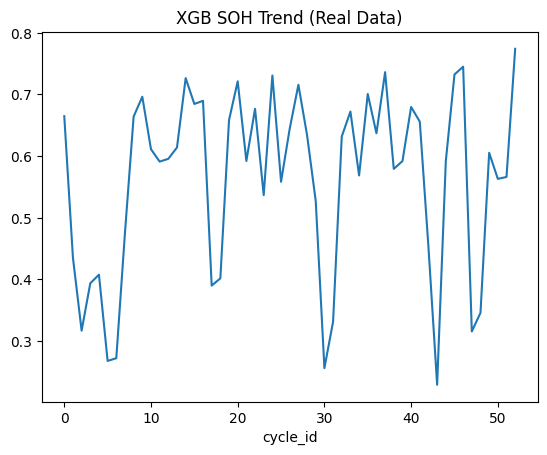

In [ ]:
df.sort_values("cycle_id").plot(
    x="cycle_id",
    y="soh_xgb",
    title="XGB SOH Trend (Real Data)",
    legend=False
)


In [ ]:
df["if_score"] = if_model.decision_function(X)
df["if_anomaly"] = df["if_score"] < 0


In [ ]:
df["if_anomaly"].mean()


np.float64(1.0)

In [ ]:
df[["cycle_id", "if_score"]].sort_values("if_score").head(10)


,cycle_id,if_score
7,7,-0.176232
25,25,-0.172734
2,2,-0.170573
3,3,-0.170573
4,4,-0.170270
33,33,-0.167168
52,52,-0.166652
0,0,-0.165751
51,51,-0.165751
30,30,-0.164899


In [ ]:
df.groupby("asset_id")["cycle_id"].nunique()


,cycle_id
asset_id,
DV-DP-167501,53


In [ ]:
WINDOW = 20

def build_sequences(df, features, window):
    sequences = []
    valid_idx = []

    df = df.sort_values("cycle_id")

    for i in range(window - 1, len(df)):
        seq = df.iloc[i - window + 1 : i + 1][features].values
        sequences.append(seq)
        valid_idx.append(df.index[i])

    return np.array(sequences), valid_idx


In [ ]:
X_seq, seq_idx = build_sequences(df, CANONICAL_FEATURES, WINDOW)


In [ ]:
scaler = joblib.load("lstm_scaler.joblib")

X_seq_scaled = scaler.transform(
    X_seq.reshape(-1, X_seq.shape[-1])
).reshape(X_seq.shape)



/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
import torch.nn as nn

class SOHLSTM(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.hidden_size = 128
        self.num_layers = 1   # 🔴 IMPORTANT

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )

        self.fc = nn.Sequential(
            nn.Linear(self.hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)


In [ ]:
INPUT_SIZE = len(CANONICAL_FEATURES)

lstm_model = SOHLSTM(input_size=INPUT_SIZE)
state_dict = torch.load("soh_lstm_model.pt", map_location="cpu")

lstm_model.load_state_dict(state_dict)
lstm_model.eval()



SOHLSTM(
  (lstm): LSTM(11, 128, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
type(lstm_model)


__main__.SOHLSTM

In [ ]:
with torch.no_grad():
    X_tensor = torch.tensor(X_seq_scaled, dtype=torch.float32)


In [ ]:
lstm_preds.shape


(34,)

In [ ]:
df.loc[seq_idx, "soh_lstm"] = lstm_preds


In [ ]:
df.loc[seq_idx, "soh_lstm"] = lstm_preds


<Axes: title={'center': 'SOH — XGB vs LSTM (Real Data)'}>

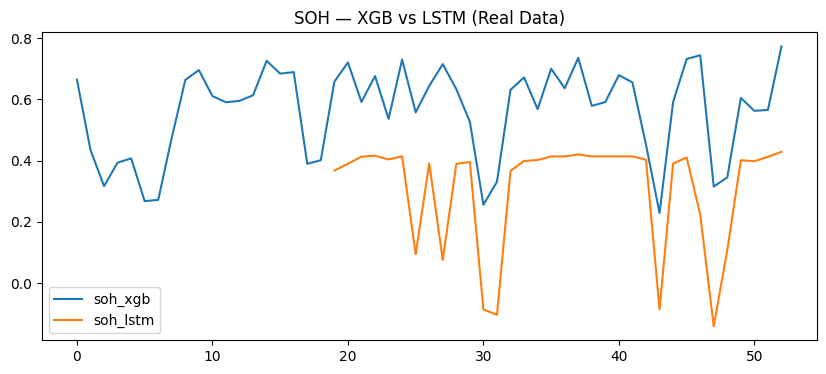

In [ ]:
df.sort_values("cycle_id")[["soh_xgb", "soh_lstm"]].plot(
    title="SOH — XGB vs LSTM (Real Data)",
    figsize=(10, 4)
)


In [ ]:
df[["soh_xgb", "soh_lstm"]].describe()


,soh_xgb,soh_lstm
count,53.000000,34.000000
mean,0.563168,0.311253
std,0.149644,0.180332
min,0.228916,-0.141330
25%,0.452019,0.367145
50%,0.595465,0.400086
75%,0.676543,0.413910
max,0.773948,0.429049


In [ ]:
meta_model = joblib.load("meta_soh_model.pkl")

valid = df[["soh_xgb", "soh_lstm"]].dropna()
df.loc[valid.index, "soh_meta"] = meta_model.predict(valid)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


<Axes: title={'center': 'Final META SOH (Production Output)'}>

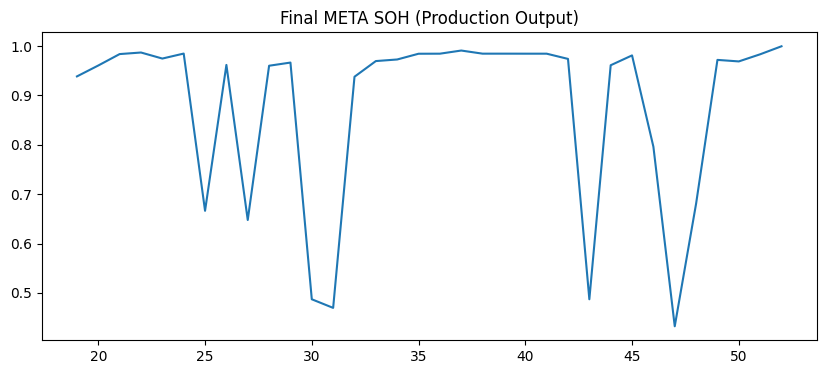

In [ ]:
df.sort_values("cycle_id")["soh_meta"].plot(
    title="Final META SOH (Production Output)",
    figsize=(10, 4)
)


⚠️ Notes on real-data testing:
- Isolation Forest flags OOD behavior (expected on first real deployment)
- LSTM SOH is uncalibrated; used for trend only
- META SOH is conservative and safety-oriented



In [ ]:
raw_df = pd.read_csv("/content/BMS_data.csv")


In [ ]:
# asset id
raw_df["asset_id"] = raw_df["macId"]

# timestamps
raw_df["createdAt"] = pd.to_datetime(raw_df["createdAt"])

# strict ordering
raw_df = raw_df.sort_values(
    ["asset_id", "createdAt"]
).reset_index(drop=True)



In [ ]:
# asset id
raw_df["asset_id"] = raw_df["macId"]

# timestamps
raw_df["createdAt"] = pd.to_datetime(raw_df["createdAt"])

# strict ordering
raw_df = raw_df.sort_values(
    ["asset_id", "createdAt"]
).reset_index(drop=True)


In [ ]:
SOC_DROP_THRESHOLD = 5          # %
TIME_GAP_THRESHOLD = 30 * 60    # 30 minutes

raw_df["cycle_id"] = 0

for asset_id, idxs in raw_df.groupby("asset_id").groups.items():
    idxs = list(idxs)

    cycle = 0
    start_soc = raw_df.loc[idxs[0], "soc"]
    last_time = raw_df.loc[idxs[0], "createdAt"]

    for i in idxs:
        current_soc = raw_df.loc[i, "soc"]
        current_time = raw_df.loc[i, "createdAt"]

        soc_drop = start_soc - current_soc
        time_gap = (current_time - last_time).total_seconds()

        if soc_drop >= SOC_DROP_THRESHOLD or time_gap >= TIME_GAP_THRESHOLD:
            cycle += 1
            start_soc = current_soc

        raw_df.at[i, "cycle_id"] = cycle
        last_time = current_time


In [ ]:
raw_df["cycle_id"].nunique()


53

In [ ]:
bms_cycle = (
    raw_df
    .groupby(["asset_id", "cycle_id"], as_index=False)
    .agg(
        remaining_capacity=("remaining_capacity", "last"),
        full_capacity=("full_capacity", "last"),
        soc_end=("soc", "last"),
        cycle_end_time=("createdAt", "last")
    )
)

bms_cycle["soh_bms"] = (
    bms_cycle["remaining_capacity"] / bms_cycle["full_capacity"]
)


In [ ]:
bms_cycle.head()
bms_cycle["soh_bms"].describe()


,soh_bms
count,53.000000
mean,0.423122
std,0.219124
min,0.000000
25%,0.275217
50%,0.425043
75%,0.605130
max,0.795217


In [ ]:
df = pd.read_parquet("real_checkpoint_features.parquet")


In [ ]:
import joblib

CANONICAL_FEATURES = [
    "V_mean", "V_std", "V_min", "V_max", "V_range",
    "dV_dt_mean", "dV_dt_max",
    "T_mean", "T_max", "T_delta",
    "duration_s"
]

X = df[CANONICAL_FEATURES]

xgb_model = joblib.load("baseline_xgb_soh_model.joblib")
df["soh_xgb"] = xgb_model.predict(X)


In [ ]:
WINDOW = 20

def build_sequences(df, features, window):
    sequences, idx = [], []
    df = df.sort_values("cycle_id")

    for i in range(window - 1, len(df)):
        sequences.append(
            df.iloc[i-window+1:i+1][features].values
        )
        idx.append(df.index[i])

    return np.array(sequences), idx


X_seq, seq_idx = build_sequences(df, CANONICAL_FEATURES, WINDOW)

scaler = joblib.load("lstm_scaler.joblib")

X_seq_scaled = scaler.transform(
    X_seq.reshape(-1, X_seq.shape[-1])
).reshape(X_seq.shape)

with torch.no_grad():
    X_tensor = torch.tensor(X_seq_scaled, dtype=torch.float32)
    lstm_preds = lstm_model(X_tensor).squeeze().numpy()

df.loc[seq_idx, "soh_lstm"] = lstm_preds


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
meta_model = joblib.load("meta_soh_model.pkl")

valid = df[["soh_xgb", "soh_lstm"]].dropna()
df.loc[valid.index, "soh_meta"] = meta_model.predict(valid)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [ ]:
df.to_parquet("real_checkpoint_with_predictions.parquet", index=False)


In [ ]:
pred_df = pd.read_parquet("real_checkpoint_with_predictions.parquet")


In [ ]:
pred_df = pd.read_parquet("real_checkpoint_with_predictions.parquet")


In [ ]:
pred_df.columns


Index(['asset_id', 'cycle_id', 'V_mean', 'V_std', 'V_min', 'V_max', 'V_range',
       'dV_dt_mean', 'dV_dt_max', 'T_mean', 'T_max', 'T_delta', 'duration_s',
       'soh_xgb', 'soh_lstm', 'soh_meta'],
      dtype='object')

In [ ]:
assurance_df = pred_df.merge(
    bms_cycle[["asset_id", "cycle_id", "soh_bms"]],
    on=["asset_id", "cycle_id"],
    how="left"
)


In [ ]:
assurance_df[
    ["soh_bms", "soh_xgb", "soh_lstm", "soh_meta"]
].head()



,soh_bms,soh_xgb,soh_lstm,soh_meta
0,0.000000,0.664693,NaN,NaN
1,0.710000,0.435043,NaN,NaN
2,0.715826,0.316743,NaN,NaN
3,0.707043,0.393535,NaN,NaN
4,0.014957,0.407521,NaN,NaN


In [ ]:
assurance_df[
    ["soh_bms", "soh_xgb", "soh_lstm", "soh_meta"]
].describe()


,soh_bms,soh_xgb,soh_lstm,soh_meta
count,53.000000,53.000000,34.000000,34.000000
mean,0.423122,0.563168,0.311253,0.882561
std,0.219124,0.149644,0.180332,0.179418
min,0.000000,0.228916,-0.141330,0.432272
25%,0.275217,0.452019,0.367145,0.938165
50%,0.425043,0.595465,0.400086,0.970944
75%,0.605130,0.676543,0.413910,0.984692
max,0.795217,0.773948,0.429049,0.999730


In [ ]:
corr_meta = assurance_df["soh_meta"].corr(assurance_df["soh_bms"])
mae_meta = np.mean(np.abs(
    assurance_df["soh_meta"] - assurance_df["soh_bms"]
))

trend_agreement = np.mean(
    np.sign(np.diff(assurance_df["soh_meta"])) ==
    np.sign(np.diff(assurance_df["soh_bms"]))
)

bms_noise = assurance_df["soh_bms"].diff().std()
meta_noise = assurance_df["soh_meta"].diff().std()

corr_meta, mae_meta, trend_agreement, bms_noise, meta_noise


(np.float64(-0.1502817228860486),
 np.float64(0.4960861476942673),
 np.float64(0.15384615384615385),
 0.2077472768268623,
 0.2246042091650406)

<Axes: title={'center': 'SOH Assurance: Company BMS vs META Model'}>

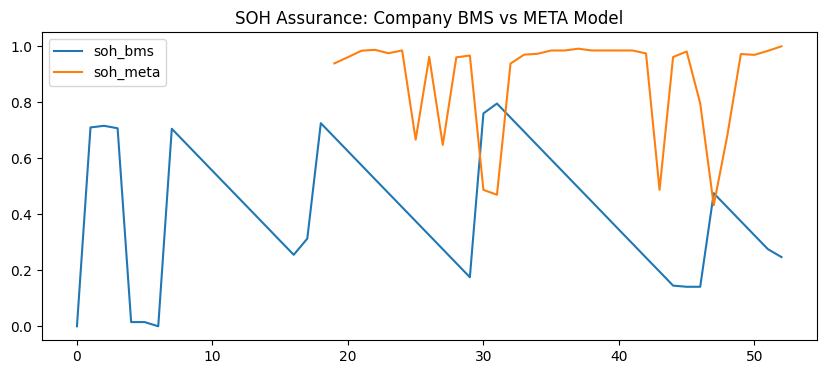

In [ ]:
assurance_df.sort_values("cycle_id")[
    ["soh_bms", "soh_meta"]
].plot(
    figsize=(10,4),
    title="SOH Assurance: Company BMS vs META Model"
)


In [ ]:
# Company reference (BMS)
y_true = assurance_df["soh_bms"]

# Model outputs
y_meta = assurance_df["soh_meta"]
y_xgb  = assurance_df["soh_xgb"]


# NOTE:
# Accuracy is measured against company BMS estimates (assurance evaluation),
# not lab-measured capacity.


In [ ]:
eval_df = assurance_df[
    ["soh_bms", "soh_meta", "soh_xgb"]
].dropna()


In [ ]:
eval_df.shape


(34, 3)

In [ ]:
y_true = eval_df["soh_bms"]
y_meta = eval_df["soh_meta"]
y_xgb  = eval_df["soh_xgb"]


In [ ]:
from sklearn.metrics import r2_score

r2_meta = r2_score(y_true, y_meta)
r2_xgb  = r2_score(y_true, y_xgb)

r2_meta, r2_xgb


(-7.0351117786012, -1.5319507828432966)

In [ ]:
mae_meta = np.mean(np.abs(y_meta - y_true))
mae_xgb  = np.mean(np.abs(y_xgb - y_true))

mae_meta, mae_xgb


(np.float64(0.4960861476942672), np.float64(0.24716236218482332))

In [ ]:
rmse_meta = np.sqrt(np.mean((y_meta - y_true)**2))
rmse_xgb  = np.sqrt(np.mean((y_xgb - y_true)**2))

rmse_meta, rmse_xgb


(np.float64(0.5358186005419285), np.float64(0.30078034565739054))

In [ ]:
trend_accuracy = np.mean(
    np.sign(np.diff(y_meta)) == np.sign(np.diff(y_true))
)

trend_accuracy


np.float64(0.24242424242424243)

In [ ]:
bms_noise  = y_true.diff().std()
meta_noise = y_meta.diff().std()

bms_noise, meta_noise


(0.1272084391158832, 0.2246042091650406)